# Homework 9

* **The first part is a simple review of ROC curves.**

* **The second part asks you to perform a K-nn regression on faces.**

**import libararies**

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn import datasets
from sklearn.datasets import fetch_olivetti_faces
from sklearn.utils.validation import check_random_state

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, log_loss, classification_report, accuracy_score

## ROC curves

* Find the best value of $K$ (optimizing the AUC on the iris test data):

In [3]:
iris = datasets.load_iris()
X = iris["data"][:,3:]
y = (iris["target"]==2).astype(int)

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

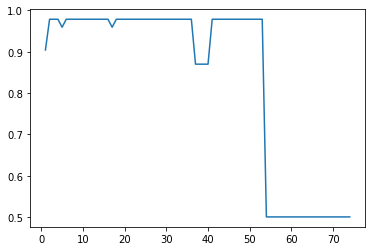

In [13]:
#attempt one with normal for loop
scores = []
neighbors = np.arange(1,len(y_test))
for i in range(1, len(y_test)):    
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    y_score = knn.predict(X_test)
    fpr, tpr, threshold = roc_curve(y_test, y_score)
    scores.append(roc_auc_score(y_test, y_score))
plt.plot(neighbors, scores)

In [41]:
#attempt two with gridsearch CV
neighbors = list(np.arange(1,60)) #60 decided as len(y_train)*0,8 (because 5-fold CV) since this value is the max
knn = KNeighborsClassifier()
grid_params = {"n_neighbors" : neighbors}
grid = GridSearchCV(knn, grid_params, scoring = "roc_auc")

grid.fit(X_train, y_train)
print(f"the best parameters are {grid.best_params_}, the best score is reached with {grid.best_score_}")

pred = grid.predict(X_test)

print(f"\nthe ROC AUC Score is {roc_auc_score(y_test, pred)}")

the best parameters are {'n_neighbors': 41}, the best score is reached with 0.986

the ROC AUC Score is 0.9782608695652174


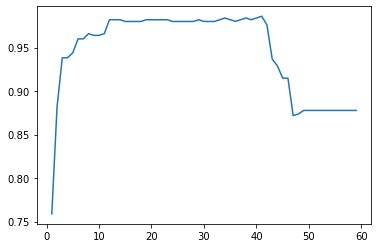

In [47]:
df = pd.DataFrame(grid.cv_results_)
plt.plot(df.param_n_neighbors, df.mean_test_score)

## Face completion 

* The goal is to predict the lower half of a face given its upper half.

* The first column of images shows true faces. The second column illustrates how linear regression completes the lower half of those faces.

* Your task is to fill the third column with k nearest neighbors predictions.


In [78]:
# Load the faces datasets
#https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html
data = fetch_olivetti_faces()
targets = data.target

data = data.images.reshape((len(data.images), -1))
train = data[targets < 30]
test = data[targets >= 30]  

In [79]:
# Test on independent people
# Test on a subset of people
n_faces = 5
rng = check_random_state(4)
face_ids = rng.randint(test.shape[0], size=(n_faces, ))
test = test[face_ids, :]

n_pixels = data.shape[1]
# Upper half of the faces
X_train = train[:, :(n_pixels + 1) // 2]

# Lower half of the faces
y_train = train[:, n_pixels // 2:]
X_test = test[:, :(n_pixels + 1) // 2]
y_test = test[:, n_pixels // 2:]

ESTIMATORS = {
    "Linear regression": 1,
    "K-nn": 2,
}
# Fit estimators
y_test_predict = dict()
estimator = LinearRegression()
estimator.fit(X_train, y_train)
y_test_predict["Linear regression"] = estimator.predict(X_test)

#The following is a placeholder that you need to change:
neighbors = []
list1 = np.arange(3,100)
for i in list1:
    if i % 2 != 0: neighbors.append(i)

grid_params = {"n_neighbors" : neighbors}
face_knn = KNeighborsRegressor()
face_grid = GridSearchCV(face_knn, grid_params)
face_grid.fit(X_train, y_train)
y_test_predict["K-nn"] = face_grid.predict(X_test)

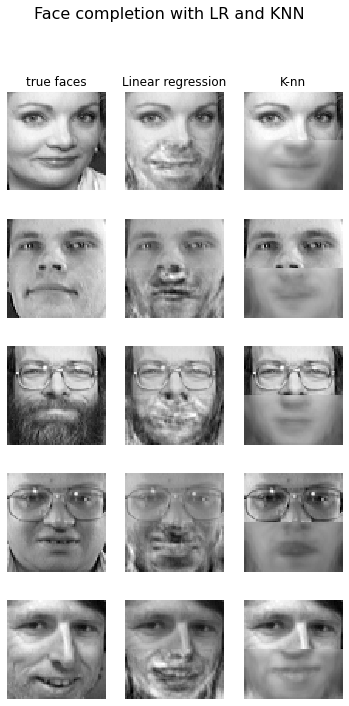

In [80]:
# Plot the completed faces
image_shape = (64, 64)

n_cols = 3
plt.figure(figsize=(2. * n_cols, 2.26 * n_faces))
plt.suptitle("Face completion with LR and KNN", size=16)

for i in range(n_faces):
    true_face = np.hstack((X_test[i], y_test[i]))

    if i:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1)
    else:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1, title="true faces")

    sub.axis("off")
    sub.imshow(true_face.reshape(image_shape),
               cmap=plt.cm.gray,
               interpolation="nearest")

    for j, est in enumerate(ESTIMATORS):
        completed_face = np.hstack((X_test[i], y_test_predict[est][i]))

        if i:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j)

        else:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j,
                              title=est)

        sub.axis("off")
        sub.imshow(completed_face.reshape(image_shape),
                   cmap=plt.cm.gray,
                   interpolation="nearest")

## Advanced

* Change the code from above to predict the right half from the left half of the face.